<a href="https://colab.research.google.com/github/DhruvAgg10/Python-projects/blob/main/turboengine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
#import random forest regression
from sklearn.ensemble import RandomForestRegressor
#import test train split
from sklearn.model_selection import train_test_split

In [ ]:
dataset_paths = {
    "FD001": "/content/train_FD001.txt",
    "FD002": "/content/train_FD002.txt",
    "FD003": "/content/train_FD003.txt",
    "FD004": "/content/train_FD004.txt"
}

Without sep=' '

When you do not specify the sep parameter, pandas assumes the default separator (a comma , for CSV files).

Since your file is space-separated, pandas reads the entire row as a single column, resulting in only one column.

With sep=' '

By specifying sep=' ' (space separator), pandas correctly interprets spaces as column dividers and properly separates the data into multiple columns.

Column Headers for Train Data

Unit Number – Unique identifier for each engine

Time (cycles) – The number of operational cycles completed

Operational Setting 1

Operational Setting 2

Operational Setting 3 6-26. Sensor Measurements 1 to 26 – Various engine sensor readings

In [ ]:

# List to store processed datasets
datasets = []

column_names = [
    "unit_number", "time_in_cycles",
    "operational_setting_1", "operational_setting_2", "operational_setting_3"
] + [f"sensor_{i}" for i in range(1, 22)]

for dataset_id, path in dataset_paths.items():
    df = pd.read_csv(path, sep='\s+', header=None)
    df.columns = column_names
    df['dataset_id'] = dataset_id

    # Make unit_number unique by appending dataset_id
    df['unit_number'] = df['unit_number'].astype(str) + "_" + dataset_id

    # Compute RUL separately
    df['RUL'] = df.groupby("unit_number")["time_in_cycles"].transform(max) - df["time_in_cycles"]

    datasets.append(df)






<ipython-input-3-74e022bc0c21>:18: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df['RUL'] = df.groupby("unit_number")["time_in_cycles"].transform(max) - df["time_in_cycles"]
<ipython-input-3-74e022bc0c21>:18: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df['RUL'] = df.groupby("unit_number")["time_in_cycles"].transform(max) - df["time_in_cycles"]
<ipython-input-3-74e022bc0c21>:18: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df['RUL'

In [ ]:
# Merge all datasets into one
merged_data = pd.concat(datasets, ignore_index=True)

print(f"Merged dataset shape: {merged_data.shape}")

Merged dataset shape: (160359, 28)


In [ ]:

# Merge all datasets
merged_data = pd.concat(datasets, ignore_index=True)

print(merged_data[['unit_number', 'dataset_id', 'RUL']].head())


  unit_number dataset_id  RUL
0     1_FD001      FD001  191
1     1_FD001      FD001  190
2     1_FD001      FD001  189
3     1_FD001      FD001  188
4     1_FD001      FD001  187


In [ ]:
print(merged_data['unit_number'].unique()[:10])  # Check first 10 unique engines


['1_FD001' '2_FD001' '3_FD001' '4_FD001' '5_FD001' '6_FD001' '7_FD001'
 '8_FD001' '9_FD001' '10_FD001']


In [ ]:
dataset_mapping = {"FD001": 1, "FD002": 2, "FD003": 3, "FD004": 4}
merged_data["dataset_id"] = merged_data["dataset_id"].map(dataset_mapping)

In [ ]:
# Check failure cycles for Engine 1 in each dataset
for dataset_id in [1, 2, 3, 4]:
    engine_1_max_cycles = merged_data[merged_data['unit_number'] == f'1_{dataset_id}']['time_in_cycles'].max()
    print(f"Engine 1 in {dataset_id} failed after {engine_1_max_cycles} cycles.")

Engine 1 in 1 failed after nan cycles.
Engine 1 in 2 failed after nan cycles.
Engine 1 in 3 failed after nan cycles.
Engine 1 in 4 failed after nan cycles.


In [ ]:
from sklearn.model_selection import train_test_split

# Define feature columns (excluding unit_number, time_in_cycles, and RUL)
features = [col for col in merged_data.columns if col not in ['unit_number', 'time_in_cycles', 'RUL']]

# Split data into training and validation sets
X = merged_data[features]
y = merged_data['RUL']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (128287, 25)
Validation data shape: (32072, 25)


In [ ]:
from lightgbm import LGBMRegressor

# Train LightGBM model
lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=7, random_state=42)
lgbm_model.fit(X_train, y_train)

print("Model training completed! ✅")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3845
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 25
[LightGBM] [Info] Start training from score 122.275110
Model training completed! ✅


In [ ]:

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)
print("Model training completed! ✅")

Model training completed! ✅


In [ ]:
from xgboost import XGBRegressor

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
print("Model training completed! ✅")


Model training completed! ✅


In [ ]:
# Import required libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Store trained models in a dictionary
models = {
    "LightGBM": lgbm_model,
    "XGBoost": xgb_model,
    "Random Forest": rf_model
}

In [ ]:
# Evaluate each model
for model_name, model in models.items():
    # Predict on validation set
    y_pred = model.predict(X_val)

    # Compute MAE & RMSE
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    # Print results
    print(f"🔹 {model_name} Results:")
    print(f"   ✅ Mean Absolute Error (MAE): {mae:.2f}")
    print(f"   ✅ Root Mean Squared Error (RMSE): {rmse:.2f}\n")


🔹 LightGBM Results:
   ✅ Mean Absolute Error (MAE): 35.84
   ✅ Root Mean Squared Error (RMSE): 50.17

🔹 XGBoost Results:
   ✅ Mean Absolute Error (MAE): 36.28
   ✅ Root Mean Squared Error (RMSE): 50.64

🔹 Random Forest Results:
   ✅ Mean Absolute Error (MAE): 35.57
   ✅ Root Mean Squared Error (RMSE): 50.15



In [ ]:
# Define test dataset paths
test_paths = {
    "FD001": "/content/test_FD001.txt",
    "FD002": "/content/test_FD002.txt",
    "FD003": "/content/test_FD003.txt",
    "FD004": "/content/test_FD004.txt"
}

# Define true RUL paths
rul_paths = {
    "FD001": "/content/RUL_FD001.txt",
    "FD002": "/content/RUL_FD002.txt",
    "FD003": "/content/RUL_FD003.txt",
    "FD004": "/content/RUL_FD004.txt"
}


In [ ]:
# Process each test dataset separately
test_datasets = []

for dataset_id, path in test_paths.items():
    # Load test dataset
    test_df = pd.read_csv(path, sep='\s+', header=None)

    # Assign column names
    test_df.columns = column_names

    # Keep only the last cycle for each engine
    test_df = test_df.groupby("unit_number").last().reset_index()

    # Make unit_number unique by appending dataset_id
    test_df["unit_number"] = test_df["unit_number"].astype(str) + "_" + dataset_id

    # Convert dataset_id to numeric
    test_df["dataset_id"] = dataset_mapping[dataset_id]

    # Load true RUL values (fix: read only first column to avoid ParserError)
    true_rul = pd.read_csv(rul_paths[dataset_id], header=None, usecols=[0], names=["True_RUL"])

    # Add true RUL to test data
    test_df["True_RUL"] = true_rul["True_RUL"]

    # Append to list
    test_datasets.append(test_df)


In [ ]:
# Merge all test datasets
merged_test_data = pd.concat(test_datasets, ignore_index=True)

print(f" Merged test dataset shape: {merged_test_data.shape}")


 Merged test dataset shape: (707, 28)


In [ ]:
print(merged_test_data[['unit_number', 'dataset_id', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3']].head(10))


  unit_number  dataset_id  operational_setting_1  operational_setting_2  \
0     1_FD001           1                -0.0006                 0.0004   
1     2_FD001           1                 0.0018                -0.0001   
2     3_FD001           1                -0.0016                 0.0004   
3     4_FD001           1                 0.0012                 0.0004   
4     5_FD001           1                -0.0013                -0.0004   
5     6_FD001           1                 0.0076                -0.0003   
6     7_FD001           1                 0.0016                -0.0001   
7     8_FD001           1                 0.0016                -0.0005   
8     9_FD001           1                -0.0003                 0.0004   
9    10_FD001           1                -0.0018                 0.0004   

   operational_setting_3  
0                  100.0  
1                  100.0  
2                  100.0  
3                  100.0  
4                  100.0  
5           

In [ ]:
# Loop through models and evaluate on test data
for model_name, model in models.items():
    # Predict RUL
    X_test = merged_test_data[features]  # Using 'features' defined earlier
    merged_test_data[f"Predicted_RUL_{model_name}"] = model.predict(X_test)

    # Ensure the columns are numeric
    merged_test_data["True_RUL"] = pd.to_numeric(merged_test_data["True_RUL"], errors='coerce')
    merged_test_data[f"Predicted_RUL_{model_name}"] = pd.to_numeric(merged_test_data[f"Predicted_RUL_{model_name}"], errors='coerce')

    # Drop rows with NaN values in either prediction or true RUL
    eval_df = merged_test_data.dropna(subset=["True_RUL", f"Predicted_RUL_{model_name}"])

    # Compute MAE & RMSE
    mae = mean_absolute_error(eval_df["True_RUL"], eval_df[f"Predicted_RUL_{model_name}"])
    rmse = np.sqrt(mean_squared_error(eval_df["True_RUL"], eval_df[f"Predicted_RUL_{model_name}"]))

    # Print evaluation metrics
    print(f"✅ {model_name} Test Accuracy Results:")
    print(f"   🔹 Mean Absolute Error (MAE): {mae:.2f}")
    print(f"   🔹 Root Mean Squared Error (RMSE): {rmse:.2f}\n")


✅ LightGBM Test Accuracy Results:
   🔹 Mean Absolute Error (MAE): 28.51
   🔹 Root Mean Squared Error (RMSE): 38.90

✅ XGBoost Test Accuracy Results:
   🔹 Mean Absolute Error (MAE): 29.85
   🔹 Root Mean Squared Error (RMSE): 40.01

✅ Random Forest Test Accuracy Results:
   🔹 Mean Absolute Error (MAE): 28.40
   🔹 Root Mean Squared Error (RMSE): 39.76



1️⃣ If MAE < 30 & RMSE < 50, model is industry-ready ✅

In [ ]:

# Define a function to predict RUL based on user input
def predict_rul(op1, op2, op3, sensor_values, dataset_id):
    """
    Predicts Remaining Useful Life (RUL) given operational settings and sensor values.

    Parameters:
    - op1, op2, op3: Operational settings
    - sensor_values: List of 21 sensor readings
    - dataset_id: Numeric ID of dataset (1=FD001, 2=FD002, 3=FD003, 4=FD004)

    Returns:
    - Predicted RUL
    """
    # Ensure input matches the model's expected feature format
    input_data = np.array([[op1, op2, op3] + sensor_values + [dataset_id]])

    # Predict RUL using the trained LightGBM model
    predicted_rul = lgbm_model.predict(input_data)[0]

    return predicted_rul

Enter all 26 values (unit_number, time_in_cycles, op1, op2, op3, sensor1 to sensor21):
1 2 -0.0027 -0.0003 100.0 518.67 641.71 1588.45 1395.42 14.62 21.61 554.85 2388.01 9054.42 1.30 47.50 522.16 2388.06 8139.62 8.3803 0.03 393 2388 100.00 39.02 23.3916
Enter Dataset ID (1=FD001, 2=FD002, 3=FD003, 4=FD004): 1

🔧 Predicted Remaining Useful Life (RUL): 162.63 cycles
📊 Engine has already run for 2 cycles.
📈 Total Estimated Life: 164.63 cycles


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


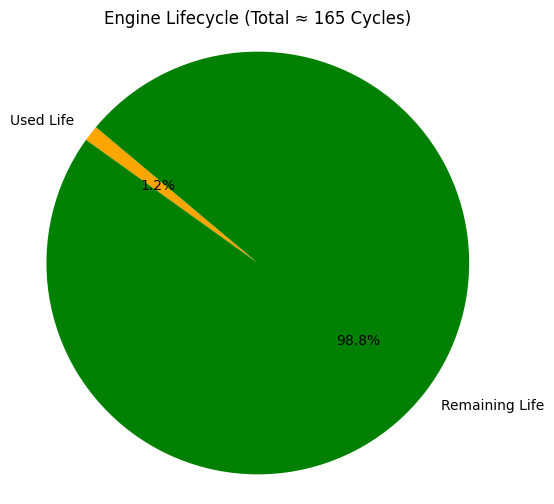

In [ ]:
import matplotlib.pyplot as plt

# Input all 26 values in one line
raw_input = input("Enter all 26 values (unit_number, time_in_cycles, op1, op2, op3, sensor1 to sensor21):\n")
values = list(map(float, raw_input.strip().split()))

# Unpack values
unit_number = int(values[0])
time_in_cycles = int(values[1])
op1, op2, op3 = values[2:5]
sensor_values = values[5:]

# Dataset ID
dataset_id = int(input("Enter Dataset ID (1=FD001, 2=FD002, 3=FD003, 4=FD004): "))

# Predict RUL
predicted_rul = predict_rul(op1, op2, op3, sensor_values, dataset_id)

# Calculate total life
total_life = predicted_rul + time_in_cycles

# Show RUL result
print(f"\n🔧 Predicted Remaining Useful Life (RUL): {predicted_rul:.2f} cycles")
print(f"📊 Engine has already run for {time_in_cycles} cycles.")
print(f"📈 Total Estimated Life: {total_life:.2f} cycles")

# Plot Pie Chart
labels = ['Used Life', 'Remaining Life']
sizes = [time_in_cycles, predicted_rul]
colors = ['orange', 'green']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title(f"Engine Lifecycle (Total ≈ {total_life:.0f} Cycles)")
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle.
plt.show()



1 2 -0.0027 -0.0003 100.0 518.67 641.71 1588.45 1395.42 14.62 21.61 554.85 2388.01 9054.42 1.30 47.50 522.16 2388.06 8139.62 8.3803 0.03 393 2388 100.00 39.02 23.3916  

In [ ]:
import joblib

# Save the trained Random Forest model
joblib.dump(rf_model, "/content/rul_random_forest_model.pkl")

print(" Random Forest Model Saved for Deployment!")


 Random Forest Model Saved for Deployment!


Enter all 26 values (unit_number, time_in_cycles, op1, op2, op3, sensor1 to sensor21):
1 2 -0.0027 -0.0003 100.0 518.67 641.71 1588.45 1395.42 14.62 21.61 554.85 2388.01 9054.42 1.30 47.50 522.16 2388.06 8139.62 8.3803 0.03 393 2388 100.00 39.02 23.3916

🧮 Predicted RUL: 163.80 cycles
⏱️ Used Life (entered): 2.00 cycles
📊 Total Estimated Life: 165.80 cycles


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


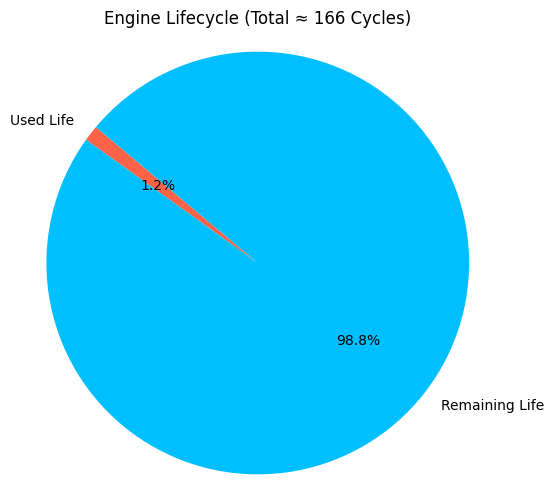

In [ ]:
import joblib
import matplotlib.pyplot as plt

# Load the trained model
rf_model = joblib.load("rul_random_forest_model.pkl")

# Input from user
raw_input = input("Enter all 26 values (unit_number, time_in_cycles, op1, op2, op3, sensor1 to sensor21):\n")
values = list(map(float, raw_input.replace(",", " ").strip().split()))

# Unpack values
unit_number = values[0]
time_in_cycles = values[1]  # Engine's age (used life)
features = values[2:] + [2]  # Add dataset ID at end (FD002 in this example)

# Predict RUL
predicted_rul = rf_model.predict([features])[0]

# Compute total life
total_life = time_in_cycles + predicted_rul

# Output
print(f"\n🧮 Predicted RUL: {predicted_rul:.2f} cycles")
print(f"⏱️ Used Life (entered): {time_in_cycles:.2f} cycles")
print(f"📊 Total Estimated Life: {total_life:.2f} cycles")

# Pie chart
labels = ['Used Life', 'Remaining Life']
sizes = [time_in_cycles, predicted_rul]
colors = ['#FF6347', '#00BFFF']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title(f"Engine Lifecycle (Total ≈ {total_life:.0f} Cycles)")
plt.axis('equal')
plt.show()


In [ ]:

from google.colab import files

# Download the saved model file
files.download("rul_random_forest_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>